# Imports

In [1]:
import os
from pathlib import Path
import glob

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sbs

import mne
from mne.time_frequency import tfr_morlet, psd_multitaper, psd_welch
from mne.datasets import somato
import mne_bids

import pandas as pd
import scipy.signal as sig
import scipy.stats as stats
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.decomposition import PCA
from skimage import measure
import pickle

# Filename Parsing

In [ ]:
# Gets all the paths of vhdr files and keeps only the actual filenames (split on '-')
files = glob.glob("/Users/silumen/OneDrive - Johns Hopkins/40Hz-90/sub-*/ses-*/eeg/*.vhdr")
for i in range(len(files)):
    files[i] = files[i].split('/')[-1]
    files[i] = files[i].split('_')

# Separates the file names into components    
files = np.array(files)
subs, session, task, run = files[:, 0], files[:, 1], files[:, 2], files[:, 3]

# Parses the information from the files for mne bids
for i in range(len(files)):
    subs[i] = int(subs[i].split('-')[-1])
    session[i] = session[i].split('-')[-1]
    task[i] = task[i].split('-')[-1]
    run[i] = int(run[i].split('-')[-1])
    
# saves information to csv
data = {'id':subs, 'session':session, 'run':run, 'task':task}
df = pd.DataFrame(data)
df.to_csv('jhu_patients.csv')

In [3]:
# loads from csv and removes duplicates from same patient
data = pd.read_csv('jhu_patients.csv', index_col = 0)
data = data.drop_duplicates('id')

# PLV Calculations

In [ ]:
def plv(sig1, sig2):
    '''
    Function that takes in 2 signals and calculates the PLV value between those
    '''
    diff = sig1-sig2
    diff = np.array([complex(0, a) for a in diff])
    return np.abs(np.sum(np.exp(diff))) / len(diff)

In [ ]:
# Prevents prints from occuring for ease of reading code (can be removed)
%%capture

# sets the path for files
root = Path('/Users/silumen/OneDrive - Johns Hopkins/40Hz-90/')

# creates directory for numpy files and for figures
if not os.path.exists(os.path.join(root, 'derivatives/plv_time/')):
    os.makedirs(os.path.join(root, 'derivatives/plv_time/'))
numpy_path = os.path.join(root, 'derivatives/plv_time/')

if not os.path.exists(os.path.join(root, 'derivatives/figures/plv_time/')):
    os.makedirs(os.path.join(root, 'derivatives/figures/plv_time/'))
figures_path = os.path.join(root, 'derivatives/figures/plv_time/')

# loops thru each of the subjects
for index, row in data.iterrows():
    # formats the fields needed for mne_bids to the correct length
    subject = '{:03d}'.format(row['id'])
    session = row['session']
    task = row['task']
    run = '{:02d}'.format(row['run'])
    acq = 'run'
    datatype = 'eeg'
    # reads in data
    bids_path = mne_bids.BIDSPath(subject=subject, session=session, task=task,
                     acquisition=None, run=run, datatype=datatype, root=root,
                     suffix='eeg', extension='.vhdr')
    raw = mne_bids.read_raw_bids(bids_path)
    
    # ensures all windows are 30 seconds
    sfreq = raw.info['sfreq']
    win_size = int(sfreq*30)
    
    # gets the channel names
    cols = np.array(raw.info['ch_names'])
    
    # sets the new dataframe of the raw data to be processed
    df = raw.to_data_frame()
    df = df.set_index('time')
    
    # keeps all channels except midline (since they may be unplugged)
    idx = []
    for i, col in enumerate(cols):
        if 'Z' in col:
            idx.append(i)
            df = df.drop([col], axis = 1)
    cols = np.delete(cols, idx)
    
    # converts raw data to numpy array
    df_array = np.array(df)
    
    # runs preprocessing to turn signal into frequency domain
    # removes the first and last 10% of datapoints to account for
    # hilbert transform
    df_array = sig.hilbert(df_array, axis = 0)
    idx = int(np.ceil(df_array.shape[0] / 10))
    df_array = df_array[idx:-1*idx, :]
    df_array = np.angle(df_array)
    df_array = np.unwrap(df_array, axis = 0)
    
    # finds the correct number of chunks to split into
    chunks = int(np.ceil(df_array.shape[0] / win_size))
    
    split_30_s = np.array_split(df_array, chunks, axis = 0)
    
    # creates path for numpy data to be stored
    if not os.path.exists(os.path.join(numpy_path, 'sub-{}'.format(subject))):
        os.makedirs(os.path.join(numpy_path, 'sub-{}'.format(subject)))
    
    folder = os.path.join(numpy_path, 'sub-{}'.format(subject))
    
    base = 'sub-{}_ses-{}_task-{}_run-{}_desc-'.format(subject, session, task, run)
    base = os.path.join(folder, base)
    
    # calculates the plv value for each split and saves it
    plv_vals = np.zeros((len(split_30_s), split_30_s[0].shape[1], split_30_s[0].shape[1]))
    
    for i in range(len(split_30_s)):
        split_val = split_30_s[i]
        for j in range(split_val.shape[1]):
            for k in range(split_val.shape[1]):
                plv_vals[i, j, k] = plv(split_val[:, j], split_val[:, k])
    
    np.save(base + '30-s-split.npy', plv_vals)
    
    # changes the order of the columns so all odds are next to each other
    # and all evens are next to each other
    odd = list(range(1, len(cols), 2))
    even = list(range(0, len(cols), 2))
    new = even + odd
    cols = cols[new]
    
    # makes path for figures
    if not os.path.exists(os.path.join(figures_path, 'sub-{}'.format(subject))):
        os.makedirs(os.path.join(figures_path, 'sub-{}'.format(subject)))
    
    direc = os.path.join(figures_path, 'sub-{}'.format(subject))
    
    filen = 'sub-{}_ses-{}_task-{}_run-{}_desc-'.format(subject, session, task, run)
    filen = os.path.join(direc, filen)
    
    # gets the mean plv value and plots it
    mean = np.mean(plv_vals, axis = 0)
    mean = mean[new, :]
    mean = mean[:, new]
    
    sbs.heatmap(data=mean, vmin = 0, vmax = 1, cmap = 'hot', square = True, xticklabels = cols, yticklabels = cols)
    plt.savefig(filen + '30-s-split-whole.png')
    plt.close()
    
    # gets the standard deviation of the plv values and plots it
    std = np.std(plv_vals, axis = 0)
    std = std[new, :]
    std = std[:, new]
    
    sbs.heatmap(data = std, vmin = 0, vmax = 0.3, cmap = 'hot', square = True, xticklabels = cols, yticklabels = cols)
    plt.savefig(filen + '30-s-split-std.png')
    plt.close()
    
    # plots the plv values for each of the windows
    for i in range(plv_vals.shape[0]):
        window = plv_vals[i, :, :]
        window = window[new, :]
        window = window[:, new]

        sbs.heatmap(data = window, vmin = 0, vmax = 1, cmap = 'hot', square = True, xticklabels = cols, yticklabels = cols)
        plt.savefig(filen + 'split-{}-{}.png'.format(plv_vals.shape[0], i+1))
        plt.close()

# Feature Creation

In [ ]:
# same as above, captures figures and outputs, loops thru all patients
%%capture

# sets the path for files
root = Path('/Users/silumen/OneDrive - Johns Hopkins/40Hz-90/')

# creates directory for numpy files and for figures
if not os.path.exists(os.path.join(root, 'derivatives/plv_time/')):
    os.makedirs(os.path.join(root, 'derivatives/plv_time/'))
numpy_path = os.path.join(root, 'derivatives/plv_time/')

if not os.path.exists(os.path.join(root, 'derivatives/figures/plv_time/')):
    os.makedirs(os.path.join(root, 'derivatives/figures/plv_time/'))
figures_path = os.path.join(root, 'derivatives/figures/plv_time/')

for index, row in data.iterrows():
    subject = '{:03d}'.format(row['id'])
    session = row['session']
    task = row['task']
    run = '{:02d}'.format(row['run'])
    acq = 'run'
    datatype = 'eeg'
    bids_path = mne_bids.BIDSPath(subject=subject, session=session, task=task,
                     acquisition=None, run=run, datatype=datatype, root=root,
                     suffix='eeg', extension='.vhdr')
    raw = mne_bids.read_raw_bids(bids_path)
    
    # loads in the numpy data
    folder = os.path.join(numpy_path, 'sub-{}'.format(subject))
    
    base = 'sub-{}_ses-{}_task-{}_run-{}_desc-'.format(subject, session, task, run)
    base = os.path.join(folder, base)
    
    plv_vals = np.load(base + '30-s-split.npy')
    
    # precreates arrays for total absolute difference, total relative absolute difference
    # individual absolute difference and individual relative absolute difference
    abs_diff = np.zeros((plv_vals.shape[1], plv_vals.shape[2]))
    rel_diff = abs_diff.copy()
    abs_diff_ind = np.zeros((plv_vals.shape[0]-1, plv_vals.shape[1], plv_vals.shape[2]))
    rel_diff_ind = abs_diff_ind.copy()
    
    # calculates the 4 values mentioned above
    for i in range(plv_vals.shape[0]-1):
        diff = np.abs(plv_vals[i] - plv_vals[i+1])
        denom = (np.abs(plv_vals[i]) + np.abs(plv_vals[i+1])) / 2
        
        abs_diff_ind[i] = diff
        rel_diff_ind[i] = diff / denom
        abs_diff = abs_diff + diff
        rel_diff = rel_diff + diff / denom
    
    # saves the numpy data
    np.save(base + '30-s-split-abs-diff.npy', abs_diff)
    np.save(base + '30-s-split-rel-diff.npy', rel_diff)
    np.save(base + '30-s-split-abs-diff-ind.npy', abs_diff_ind)
    np.save(base + '30-s-split-rel-diff-ind.npy', rel_diff_ind)
    
    # calculates entropy and variance across the channels for each of the differences
    abs_ent = stats.entropy(abs_diff, axis = 0)
    abs_var = np.var(abs_diff, axis = 0)
    
    rel_ent = stats.entropy(rel_diff, axis = 0)
    rel_var = np.var(rel_diff, axis = 0)
    
    np.save(base + '30-s-split-abs-ent.npy', abs_ent)
    np.save(base + '30-s-split-abs-var.npy', abs_var)
    
    np.save(base + '30-s-split-rel-ent.npy', rel_ent)
    np.save(base + '30-s-split-rel-var.npy', rel_var)
    
    # saves the figure for relative difference
    direc = os.path.join(figures_path, 'sub-{}'.format(subject))
    
    filen = 'sub-{}_ses-{}_task-{}_run-{}_desc-'.format(subject, session, task, run)
    filen = os.path.join(direc, filen)
    
    sbs.heatmap(data=rel_diff, cmap = 'hot', square = True, xticklabels = cols, yticklabels = cols)
    plt.savefig(filen + '30-s-rel-diff.png')
    plt.close()

# Feature Loading

In [6]:
# creates lists for features
labels = []

abs_ent_list = []
abs_var_list = []

rel_ent_list = []
rel_var_list = []
rel_diff_list = []

# sets the path for files
root = Path('/Users/silumen/OneDrive - Johns Hopkins/40Hz-90/')

# creates directory for numpy files and for figures
if not os.path.exists(os.path.join(root, 'derivatives/plv_time/')):
    os.makedirs(os.path.join(root, 'derivatives/plv_time/'))
numpy_path = os.path.join(root, 'derivatives/plv_time/')

if not os.path.exists(os.path.join(root, 'derivatives/figures/plv_time/')):
    os.makedirs(os.path.join(root, 'derivatives/figures/plv_time/'))
figures_path = os.path.join(root, 'derivatives/figures/plv_time/')

for index, row in data.iterrows():
    subject = '{:03d}'.format(row['id'])
    session = row['session']
    task = row['task']
    run = '{:02d}'.format(row['run'])
    acq = 'run'
    datatype = 'eeg'
    
    folder = os.path.join(numpy_path, 'sub-{}'.format(subject))
    
    base = 'sub-{}_ses-{}_task-{}_run-{}_desc-'.format(subject, session, task, run)
    base = os.path.join(folder, base)
    
    # gets labels and loads features
    if subject[0] == '0':
        labels.append(0)
    elif subject[0] == '1':
        labels.append(1)
    else:
        labels.append(2)
    
    abs_ent = np.load(base + '30-s-split-abs-ent.npy')
    abs_var = np.load(base + '30-s-split-abs-var.npy')
    
    rel_ent = np.load(base + '30-s-split-rel-ent.npy')
    rel_var = np.load(base + '30-s-split-rel-var.npy')
    rel_diff = np.load(base + '30-s-split-rel-diff.npy')
    
    rel_diff = stats.skew(rel_diff.flatten(), axis = None)
        
    abs_ent_list.append(abs_ent)
    abs_var_list.append(abs_var)
    
    rel_ent_list.append(rel_ent)
    rel_var_list.append(rel_var)
    rel_diff_list.append(rel_diff)
    
# turns lists into arrays for classifiers
abs_ent_arr = np.zeros((len(abs_ent_list), abs_ent_list[0].shape[0]))
abs_var_arr = abs_ent_arr.copy()

rel_ent_arr = abs_ent_arr.copy()
rel_var_arr = abs_ent_arr.copy()
rel_diff_arr = np.zeros((len(abs_ent_list)))

for i in range(len(abs_ent_list)):
    abs_ent_arr[i] = abs_ent_list[i]
    abs_var_arr[i] = abs_var_list[i]
    
    rel_ent_arr[i] = rel_ent_list[i]
    rel_var_arr[i] = rel_var_list[i]
    rel_diff_arr[i] = rel_diff_list[i]

labels = np.array(labels)

# Classifiers and Feature Selection

In [7]:
# this does feature selection between Non-epilepsy and epilepsy normal
idx = np.logical_or(labels == 0, labels == 1)
rel_var_feats = rel_var_arr[idx, :]
new_labels = labels[idx]
rel_var_feats = SelectKBest(chi2, k = 4).fit_transform(rel_var_feats, new_labels)
rel_var_feats.shape

(44, 4)

In [8]:
# performs classification using svm
clf = SVC(kernel = 'rbf', class_weight = 'balanced')
clf.fit(rel_var_feats, new_labels)
# calculates accuracy and tpr, tnr
print('The accuracy is {}'.format(clf.score(rel_var_feats, new_labels)))

preds = clf.predict(rel_var_feats)
mask = preds[new_labels == 1] == 1
tp = preds[new_labels == 1]
tp = tp[mask]
tpr = len(tp) / len(new_labels[new_labels == 1])
print('The sensitivity is {}'.format(tpr))

mask = preds[new_labels == 0] == 0
tn = preds[new_labels == 0]
tn = tn[mask]
tnr = len(tn) / len(new_labels[new_labels == 0])
print('The specificity is {}'.format(tnr))

The accuracy is 0.8636363636363636
The sensitivity is 0.9090909090909091
The specificity is 0.8181818181818182


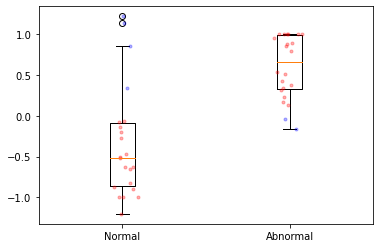

In [9]:
# plots the margin value and overlays with individual points
# red points are predicted correctly and blue points are incorrect
fig, ax = plt.subplots()
dec_vals = clf.decision_function(rel_var_feats)
plt.boxplot([dec_vals[new_labels == 0], dec_vals[new_labels == 1]])
for i in [1,2]:
    corr_points = np.logical_and(new_labels == i-1, preds == i-1)
    inc_points = np.logical_and(new_labels == i-1, preds != i-1)
    x_vals = np.random.normal(i, 0.04, size=len(dec_vals[corr_points]))
    plt.plot(x_vals, dec_vals[corr_points], 'r.', alpha=0.3)
    x_vals = np.random.normal(i, 0.04, size=len(dec_vals[inc_points]))
    plt.plot(x_vals, dec_vals[inc_points], 'b.', alpha=0.3)
ax.set_xticklabels(['Normal', 'Abnormal'])
plt.show()

In [10]:
# this does classification between Normal and abnormal eeg
norm_idx = np.logical_or(labels == 0, labels == 1)
norm_labels = labels.copy()
norm_labels[norm_idx] = 0
norm_labels[norm_labels == 2] = 1
rel_var_feats = SelectKBest(chi2, k = 4).fit_transform(rel_var_arr, norm_labels)
rel_var_feats.shape

(70, 4)

In [11]:
# performs classification using svm
clf = SVC(kernel = 'rbf', class_weight = 'balanced')
clf.fit(rel_var_feats, norm_labels)
# calculates accuracy and tpr, tnr
print('The accuracy is {}'.format(clf.score(rel_var_feats, norm_labels)))

preds = clf.predict(rel_var_feats)
mask = preds[norm_labels == 1] == 1
tp = preds[norm_labels == 1]
tp = tp[mask]
tpr = len(tp) / len(norm_labels[norm_labels == 1])
print('The sensitivity is {}'.format(tpr))

mask = preds[norm_labels == 0] == 0
tn = preds[norm_labels == 0]
tn = tn[mask]
tnr = len(tn) / len(norm_labels[norm_labels == 0])
print('The specificity is {}'.format(tnr))

The accuracy is 0.7428571428571429
The sensitivity is 0.8076923076923077
The specificity is 0.7045454545454546


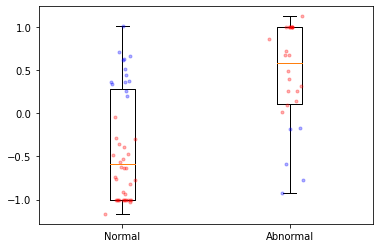

In [12]:
# plots the margin value and overlays with individual points
# red points are predicted correctly and blue points are incorrect
fig, ax = plt.subplots()
dec_vals = clf.decision_function(rel_var_feats)
plt.boxplot([dec_vals[norm_labels == 0], dec_vals[norm_labels == 1]])
for i in [1,2]:
    corr_points = np.logical_and(norm_labels == i-1, preds == i-1)
    inc_points = np.logical_and(norm_labels == i-1, preds != i-1)
    x_vals = np.random.normal(i, 0.04, size=len(dec_vals[corr_points]))
    plt.plot(x_vals, dec_vals[corr_points], 'r.', alpha=0.3)
    x_vals = np.random.normal(i, 0.04, size=len(dec_vals[inc_points]))
    plt.plot(x_vals, dec_vals[inc_points], 'b.', alpha=0.3)
ax.set_xticklabels(['Normal', 'Abnormal'])
plt.show()